## Ques1. Convert the code of Question 1 of Assignment -II (K-Fold Cross Validation with Linear Regression) to GPU accelerated code (using CuDF, CuPy, and CuML). Compare the time taken to execute each cell in each case (Use %%time as firat line in each cell for it).

In [22]:
%%time

import cupy as cp
import cudf
import cuml

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.78 µs


In [23]:
%%time

df = cudf.read_csv('USA_Housing.csv')
df

CPU times: user 5.17 ms, sys: 0 ns, total: 5.17 ms
Wall time: 3.65 ms


,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05
...,...,...,...,...,...,...
4995,60567.94414,7.830362,6.137356,3.46,22837.36103,1.060194e+06
4996,78491.27543,6.999135,6.576763,4.02,25616.11549,1.482618e+06
4997,63390.68689,7.250591,4.805081,2.13,33266.14549,1.030730e+06
4998,68001.33124,5.534388,7.130144,5.44,42625.62016,1.198657e+06


In [24]:
%%time

# check for missing values
df.isnull().values.any()

CPU times: user 0 ns, sys: 3.03 ms, total: 3.03 ms
Wall time: 2.57 ms


array(False)

In [25]:
%%time

df.isnull().sum()

CPU times: user 4.95 ms, sys: 0 ns, total: 4.95 ms
Wall time: 4.32 ms


Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
dtype: uint64

CPU times: user 1.97 s, sys: 188 ms, total: 2.16 s
Wall time: 2.16 s


<AxesSubplot:>

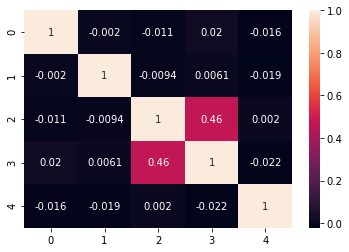

In [28]:
%%time

# check for relation between feature
import seaborn as sns
sns.heatmap(df.iloc[:,:5].corr().as_gpu_matrix(), annot=True)

In [29]:
%%time

X = df.iloc[:,:5]
y = df.iloc[:,5]

CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 2.57 ms


In [30]:
%%time

from cuml.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)

             0         1         2         3         4
0     1.028660 -0.296927  0.021274  0.088062 -1.317599
1     1.000808  0.025902 -0.255506 -0.722301  0.403999
2    -0.684629 -0.112303  1.516243  0.930840  0.072410
3    -0.491499  1.221572 -1.393077 -0.584540 -0.186734
4    -0.807073 -0.944834  0.846742  0.201513 -0.988387
...        ...       ...       ...       ...       ...
4995 -0.752109  1.869297 -0.845588 -0.422467 -1.342732
4996  0.929740  1.030822 -0.408686  0.031337 -1.062747
4997 -0.487235  1.284470 -2.170269 -1.500251 -0.291937
4998 -0.054592 -0.446694  0.141541  1.182053  0.651116
4999 -0.288313  0.015215 -0.194342  0.071855  1.041625

[5000 rows x 5 columns]
CPU times: user 618 ms, sys: 111 µs, total: 618 ms
Wall time: 617 ms


In [31]:
%%time

# add column of 1's at 0th index
ones = cp.ones((X_scaled.shape[0], 1))
X_new = cp.hstack((ones, X_scaled.as_matrix()))
print(X_new)

[[ 1.          1.02865969 -0.29692705  0.02127433  0.08806222 -1.31759867]
 [ 1.          1.00080775  0.02590164 -0.25550611 -0.72230146  0.40399945]
 [ 1.         -0.68462915 -0.11230283  1.5162435   0.93084045  0.07240989]
 ...
 [ 1.         -0.48723454  1.28447022 -2.17026949 -1.50025059 -0.29193658]
 [ 1.         -0.05459152 -0.44669439  0.14154061  1.18205319  0.65111608]
 [ 1.         -0.28831272  0.01521477 -0.19434166  0.07185495  1.04162464]]
CPU times: user 390 ms, sys: 0 ns, total: 390 ms
Wall time: 389 ms


In [32]:
%%time

y = cp.array(y)
print(y)

[1059033.558 1505890.915 1058987.988 ... 1030729.583 1198656.872
 1298950.48 ]
CPU times: user 1.18 ms, sys: 0 ns, total: 1.18 ms
Wall time: 785 µs


In [33]:
%%time

# split the data in train and test
from cuml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.30, random_state=42)

CPU times: user 1.19 s, sys: 27.1 ms, total: 1.22 s
Wall time: 1.22 s


In [34]:
%%time

print(X_train, X_test)

[[ 1.          1.4146249   0.17713817 -0.29522457  0.39600042  0.65335792]
 [ 1.         -0.91364265  2.01410889 -1.45867925 -0.51971054  0.18295778]
 [ 1.          1.21365939 -0.58455535  1.50761046  1.01998045 -0.29223897]
 ...
 [ 1.          0.78132487  0.94889523  1.80391102 -0.68178327 -0.9390865 ]
 [ 1.         -1.63951368  0.0921311  -0.08063389 -1.5245615   0.2261797 ]
 [ 1.         -0.60952236  0.20707471  1.14076696  1.74120413  0.6902284 ]] [[ 1.         -0.2202531  -1.6750934  -0.91345935 -1.46783604 -0.12504448]
 [ 1.          1.15566758 -0.42164293 -0.18489605  0.31496405  0.13772922]
 [ 1.          0.45017452  0.09863197  0.65760556 -0.59264327  0.98111802]
 ...
 [ 1.         -0.65013218 -1.861131    1.80936295  1.8465514   0.57896078]
 [ 1.         -0.2824124   0.0850448   2.09107241 -0.44677781  2.21991953]
 [ 1.          1.10569094  0.64234441  0.31881474  0.26634223  0.66626651]]
CPU times: user 1.42 ms, sys: 0 ns, total: 1.42 ms
Wall time: 1.02 ms


In [35]:
%%time

print(y_train, y_test)

[1688642.679  1159699.966  1458912.584  ... 1554301.938   882170.3184
 1316206.247 ] [ 762391.7761 1443470.037  1684554.715  ... 1131532.919  1723397.089
 1759180.044 ]
CPU times: user 704 µs, sys: 57 µs, total: 761 µs
Wall time: 560 µs


In [36]:
%%time

# checking r2_score without cross-validation using cuml linear model
from cuml.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train,y_train)
y_predict=lr.predict(X_test)


from cuml import metrics
print(metrics.r2_score(y_test,y_predict))

0.920542443041927
CPU times: user 536 ms, sys: 181 ms, total: 716 ms
Wall time: 716 ms


## 5-fold validation applied

In [15]:
%%time

theta_list = []
predict_list = []
score_list = []

train_x = []
train_y = []

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.72 µs


In [44]:
%%time

def calculate_theta(x_train, y_train):
    x_sq = x_train.T.dot(x_train)
    x_inv = cp.linalg.inv(x_sq)
    theta = (x_inv.dot(x_train.T)).dot(y_train)
    theta_list.append(theta)
    return theta

def predict(x_test, theta):
    y_predict = x_test.dot(theta)
    predict_list.append(y_predict)
    return y_predict

def r2_score(y, y_):
    num = cp.sum((y-y_)**2)
    denom = cp.sum((y-y.mean())**2)
    score = (1-num/denom)
    return score*100

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.91 µs


In [38]:
%%time
def KFold_split(X_split,folds=5):
    fold_size=int(X_split.shape[0]/folds)
    startIndex=0
    endIndex=fold_size-1
    train=[]
    test=[]
    results=[]
    while endIndex<=X_split.shape[0]:
        test=[i for i in range(startIndex,endIndex+1)]
        train=[i for i in range(0,X_split.shape[0]) if i not in test]
        results.append(list((cp.array(train),cp.array(test))))
        startIndex+=fold_size
        endIndex+=fold_size
    return results

results = KFold_split(X_new, 5)

CPU times: user 149 ms, sys: 45 µs, total: 149 ms
Wall time: 148 ms


In [39]:
%%time
k = 5
for train_index , test_index in KFold_split(X_new,k):
    X_train, X_test, y_train, y_test = X_new[train_index,:], X_new[test_index,:], y[train_index] , y[test_index]
    theta = calculate_theta(X_train, y_train)
    y_predict = predict(X_test, theta)
    score = r2_score(y_test, y_predict)
    
    score_list.append(score)
    print("Score is: ", score, "\n")


Score is:  91.75899480765108 

Score is:  92.0301549640113 

Score is:  91.52429915320013 

Score is:  92.08503836977656 

Score is:  91.38111758717496 

CPU times: user 1.49 s, sys: 19.6 ms, total: 1.51 s
Wall time: 1.51 s


In [40]:
%%time

print(theta_list)
print(score_list)
print("Max r2_score: ", max(score_list))

[array([1231872.07704612,  229923.70318635,  164052.98579011,
        120923.57426579,    3533.77470973,  151855.58542488]), array([1232586.40453402,  228365.32287054,  165201.14881927,
        122539.46855211,    1697.03433458,  150055.81710562]), array([1231448.09063371,  230730.20810582,  163554.55706976,
        121669.08713233,    2620.25215054,  150923.12489298]), array([1.23144707e+06, 2.29921558e+05, 1.64523054e+05, 1.19737507e+05,
       1.12425659e+03, 1.51317802e+05]), array([1233028.38536436,  230778.59921985,  163755.13607252,
        121885.1351222 ,    1247.01304382,  150084.29759618])]
[array(91.75899481), array(92.03015496), array(91.52429915), array(92.08503837), array(91.38111759)]
Max r2_score:  92.08503836977656
CPU times: user 190 ms, sys: 110 µs, total: 190 ms
Wall time: 189 ms


In [41]:
%%time

# idx of best r2_score and best theta matrix
best_score_idx = score_list.index(max(score_list)) 
print(best_score_idx)

best_theta = theta_list[best_score_idx]
print(best_theta)

3
[1.23144707e+06 2.29921558e+05 1.64523054e+05 1.19737507e+05
 1.12425659e+03 1.51317802e+05]
CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 187 ms


In [42]:
%%time

# Again divide data in 70-30 and apply regression with best parameters
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(X_new, y, test_size=0.30, random_state=42)

CPU times: user 3.89 ms, sys: 3.87 ms, total: 7.76 ms
Wall time: 7.08 ms


In [43]:
%%time

new_y_predict = predict(new_X_test, best_theta)
score = r2_score(new_y_test, new_y_predict)
print(score)

91.48858841946829
CPU times: user 1.85 ms, sys: 152 µs, total: 2 ms
Wall time: 1.22 ms
